In [23]:
import pandas as pd
import yfinance as yf
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [14]:
close = data['Close']
if isinstance(close, pd.DataFrame):
    if 'AAPL' in close.columns:
        close = close['AAPL']
    else:
        close = close.iloc[:, 0]

In [15]:
dfp = close.dropna().reset_index()
dfp.columns = ['ds', 'y']

In [16]:
dfp['ds'] = pd.to_datetime(dfp['ds'], errors='coerce')
dfp['y']  = pd.to_numeric(dfp['y'], errors='coerce')
dfp = dfp.dropna(subset=['ds','y'])


In [17]:
train_p = dfp.iloc[:-60].copy()
test_p  = dfp.iloc[-60:].copy()

In [ ]:
m = Prophet(daily_seasonality=False,
            weekly_seasonality=True,
            yearly_seasonality=True)
m.fit(train_p)

10:36:44 - cmdstanpy - INFO - Chain [1] start processing
10:36:45 - cmdstanpy - INFO - Chain [1] done processing


In [28]:
future = test_p[['ds']].copy()
fcst = m.predict(future)

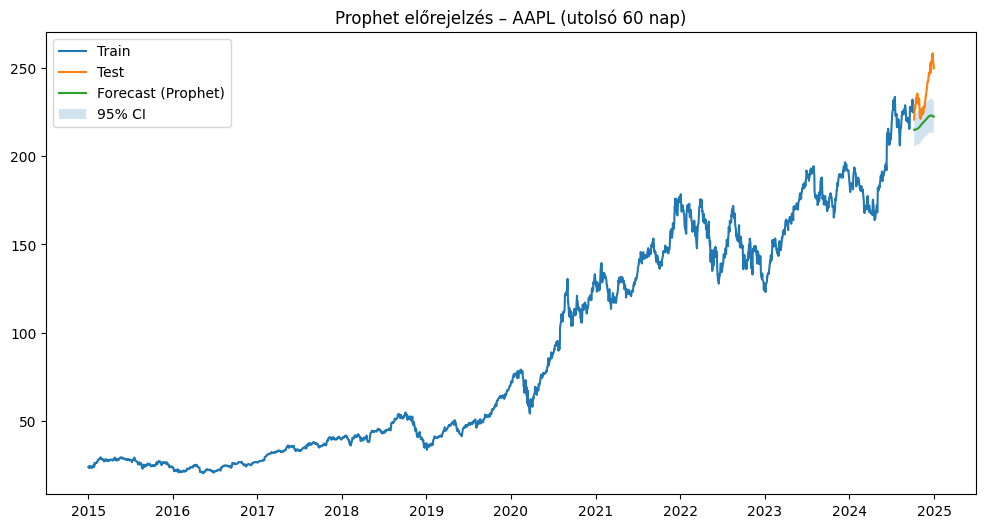

In [21]:
plt.figure(figsize=(12,6))
plt.plot(train_p['ds'], train_p['y'], label='Train')
plt.plot(test_p['ds'],  test_p['y'],  label='Test')
plt.plot(fcst['ds'],    fcst['yhat'], label='Forecast (Prophet)')
plt.fill_between(fcst['ds'], fcst['yhat_lower'], fcst['yhat_upper'], alpha=0.2, label='95% CI')
plt.legend(); plt.title('Prophet előrejelzés – AAPL (utolsó 60 nap)'); plt.show()

In [24]:
mae  = mean_absolute_error(test_p['y'], fcst['yhat'])
mape = mean_absolute_percentage_error(test_p['y'], fcst['yhat'])
print("Prophet MAE:", round(mae,2), "  MAPE:", round(mape*100,2), "%")

Prophet MAE: 16.31   MAPE: 6.79 %


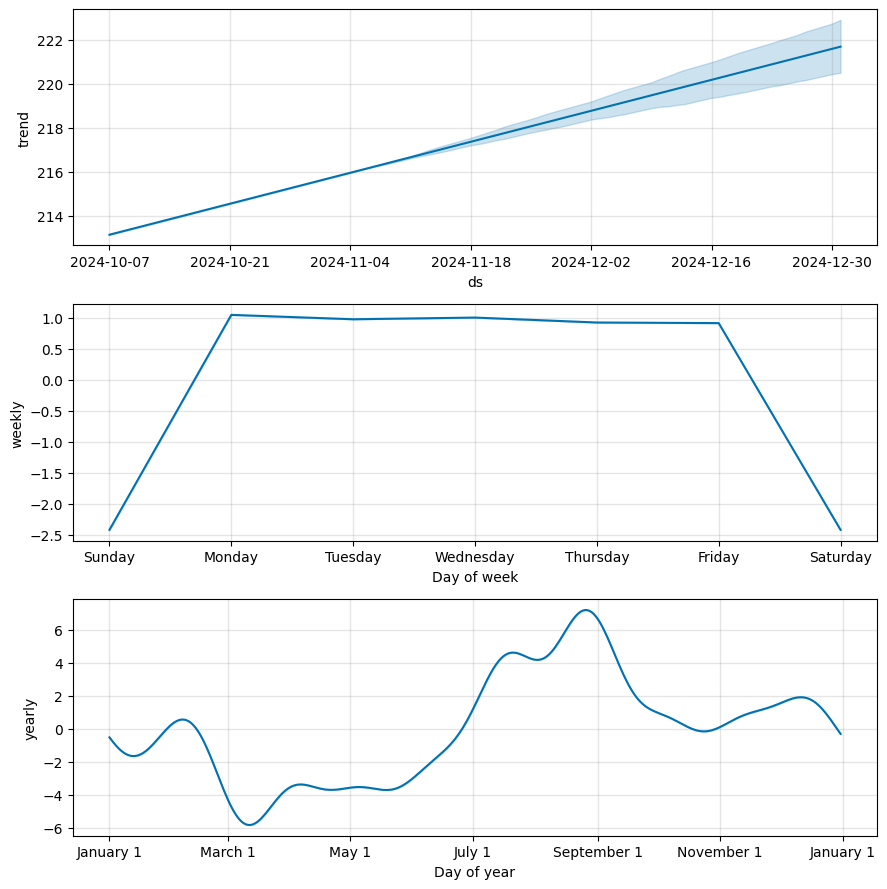

In [29]:
_ = m.plot_components(fcst)


In [32]:
param_grid = [
    # (seasonality_mode, CPS, weekly, yearly)
    ("additive",       0.05, True,  True),
    ("additive",       0.20, True,  True),
    ("multiplicative", 0.20, True,  True),
    ("multiplicative", 0.50, True,  True),
    ("multiplicative", 0.50, True,  False),
    ("multiplicative", 1.00, True,  False),
]

results = []

for mode, cps, w_seas, y_seas in param_grid:
    m = Prophet(
        daily_seasonality=False,
        weekly_seasonality=w_seas,
        yearly_seasonality=y_seas,
        seasonality_mode=mode,
        changepoint_prior_scale=cps,
        # gyorsítás: bizonytalansági minták kikapcsolása
        uncertainty_samples=0
    )
    m.fit(train_p)

    future = test_p[["ds"]].copy()
    fcst = m.predict(future)

    y_true = test_p["y"].to_numpy()
    y_pred = fcst["yhat"].to_numpy()

    mae  = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    results.append({
        "seasonality_mode": mode,
        "changepoint_prior_scale": cps,
        "weekly": w_seas,
        "yearly": y_seas,
        "MAE": mae,
        "MAPE": mape * 100
    })

df_res = pd.DataFrame(results).sort_values("MAPE")
df_res

11:29:10 - cmdstanpy - INFO - Chain [1] start processing
11:29:11 - cmdstanpy - INFO - Chain [1] done processing
11:29:11 - cmdstanpy - INFO - Chain [1] start processing
11:29:14 - cmdstanpy - INFO - Chain [1] done processing
11:29:14 - cmdstanpy - INFO - Chain [1] start processing
11:29:19 - cmdstanpy - INFO - Chain [1] done processing
11:29:19 - cmdstanpy - INFO - Chain [1] start processing
11:29:22 - cmdstanpy - INFO - Chain [1] done processing
11:29:22 - cmdstanpy - INFO - Chain [1] start processing
11:29:24 - cmdstanpy - INFO - Chain [1] done processing
11:29:24 - cmdstanpy - INFO - Chain [1] start processing
11:29:26 - cmdstanpy - INFO - Chain [1] done processing


,seasonality_mode,changepoint_prior_scale,weekly,yearly,MAE,MAPE
0,additive,0.05,True,True,16.310519,6.786761
5,multiplicative,1.00,True,False,16.620236,6.913205
4,multiplicative,0.50,True,False,16.666529,6.932873
1,additive,0.20,True,True,19.146068,7.977036
2,multiplicative,0.20,True,True,23.955685,10.048041
3,multiplicative,0.50,True,True,24.443890,10.255255
